In [5]:
from scipy.cluster.vq import kmeans2
from pyro.infer import MCMC, NUTS, Predictive, SVI, TraceMeanField_ELBO
import pyro
import pyro.contrib.gp as gp
from pyro.contrib.examples.util import get_data_directory, get_data_loader
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
train_loader = get_data_loader(dataset_name='MNIST',
                               data_dir='~/.data',
                               batch_size=1000,
                               is_training_set=True,
                               shuffle=True)
test_loader = get_data_loader(dataset_name='MNIST',
                              data_dir='~/.data',
                              batch_size=1000,
                              is_training_set=False,
                              shuffle=False)

downloading data



Extracting C:\Users\Efthymios/.data\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Efthymios/.data\MNIST\raw




Extracting C:\Users\Efthymios/.data\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Efthymios/.data\MNIST\raw




Extracting C:\Users\Efthymios/.data\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Efthymios/.data\MNIST\raw




Extracting C:\Users\Efthymios/.data\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Efthymios/.data\MNIST\raw

download complete.
downloading data
download complete.


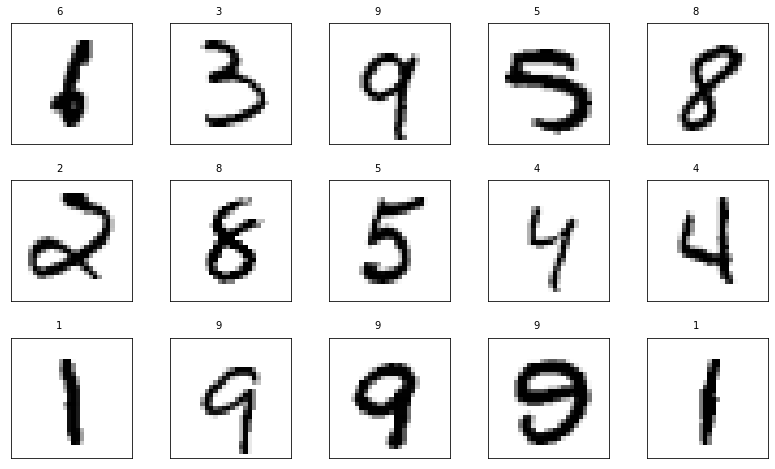

In [26]:
X = train_loader.dataset.data.float()/126
y = train_loader.dataset.targets
class_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(X.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for n, (image, label) in enumerate(zip(X[inx], y[inx])):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='binary')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -2.5, f'{class_names[label]}')
plt.show()

In [28]:
X = train_loader.dataset.data.reshape(-1, 784).float() / 126
y = train_loader.dataset.targets

In [33]:
class LinearT(nn.Module):
    """Linear transform and transpose"""
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x):
        return self.linear(x).t()

# computes the weight for mean function of the first layer;
# it is PCA of X (from 784D to 30D).
_, _, V = np.linalg.svd(X.numpy(), full_matrices=False)
W = torch.from_numpy(V[:30, :])

mean_fn = LinearT(784, 30)
mean_fn.linear.weight.data = W
mean_fn.linear.weight.requires_grad_(False);

In [34]:
class DeepGP(pyro.nn.PyroModule):
    def __init__(self, X, y, Xu, mean_fn):
        super(DeepGP, self).__init__()
        self.layer1 = gp.models.VariationalSparseGP(
            X,
            None,
            gp.kernels.RBF(784, variance=torch.tensor(2.), lengthscale=torch.tensor(2.)),
            Xu=Xu,
            likelihood=None,
            mean_function=mean_fn,
            latent_shape=torch.Size([30]))
        # make sure that the input for next layer is batch_size x 30
        h = mean_fn(X).t()
        hu = mean_fn(Xu).t()
        self.layer2 = gp.models.VariationalSparseGP(
            h,
            y,
            gp.kernels.RBF(30, variance=torch.tensor(2.), lengthscale=torch.tensor(2.)),
            Xu=hu,
            likelihood=gp.likelihoods.MultiClass(num_classes=10),
            latent_shape=torch.Size([10]))

    def model(self, X, y):
        self.layer1.set_data(X, None)
        h_loc, h_var = self.layer1.model()
        # approximate with a Monte Carlo sample (formula 15 of [1])
        h = dist.Normal(h_loc, h_var.sqrt())()
        self.layer2.set_data(h.t(), y)
        self.layer2.model()

    def guide(self, X, y):
        self.layer1.guide()
        self.layer2.guide()

    # make prediction
    def forward(self, X_new):
        # because prediction is stochastic (due to Monte Carlo sample of hidden layer),
        # we make 100 prediction and take the most common one (as in [4])
        pred = []
        for _ in range(100):
            h_loc, h_var = self.layer1(X_new)
            h = dist.Normal(h_loc, h_var.sqrt())()
            f_loc, f_var = self.layer2(h.t())
            pred.append(f_loc.argmax(dim=0))
        return torch.stack(pred).mode(dim=0)[0]

In [37]:
from scipy.cluster.vq import kmeans2
from pyro.infer import MCMC, NUTS, Predictive, SVI, TraceMeanField_ELBO
Xu = torch.from_numpy(kmeans2(X.numpy(), 100, minit='points')[0])
deepgp = DeepGP(X, y, Xu, mean_fn)
deepgp.layer1.u_scale_tril = deepgp.layer1.u_scale_tril * 1e-5
#deepgp.cuda()

optimizer = torch.optim.Adam(deepgp.parameters(), lr=0.01)
loss_fn = TraceMeanField_ELBO().differentiable_loss

In [40]:
def train(train_loader, gpmodule, optimizer, loss_fn, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        data = data.reshape(-1, 784)
        optimizer.zero_grad()
        loss = loss_fn(gpmodule.model, gpmodule.guide, data, target)
        loss.backward()
        optimizer.step()
        idx = batch_idx + 1
        if idx % 10 == 0:
            print("Train Epoch: {:2d} [{:5d}/{} ({:2.0f}%)]\tLoss: {:.6f}"
                  .format(epoch, idx * len(data), len(train_loader.dataset),
                          100. * idx / len(train_loader), loss))

def test(test_loader, gpmodule):
    correct = 0
    for data, target in test_loader:
        data, target = data, target
        data = data.reshape(-1, 784)
        pred = gpmodule(data)
        # compare prediction and target to count accuaracy
        correct += pred.eq(target).long().cpu().sum().item()

    print("\nTest set: Accuracy: {}/{} ({:.2f}%)\n"
          .format(correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [41]:
for i in range(20):
    train(train_loader, deepgp, optimizer, loss_fn, i)
    with torch.no_grad():
        test(test_loader, deepgp)

D:\Anaconda3\lib\site-packages\pyro\primitives.py:441: UserWarning: linear.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  f"{param_name} was not registered in the param store "
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log

Train Epoch:  0 [10000/60000 (17%)]	Loss: 217891.859375


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  0 [20000/60000 (33%)]	Loss: 210645.312500


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  0 [30000/60000 (50%)]	Loss: 204135.906250


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  0 [40000/60000 (67%)]	Loss: 202971.250000


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  0 [50000/60000 (83%)]	Loss: 188790.203125


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  0 [60000/60000 (100%)]	Loss: 167092.281250

Test set: Accuracy: 7613/10000 (76.13%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  1 [10000/60000 (17%)]	Loss: 125518.398438


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  1 [20000/60000 (33%)]	Loss: 88279.703125


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  1 [30000/60000 (50%)]	Loss: 68244.421875


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  1 [40000/60000 (67%)]	Loss: 58997.117188


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  1 [50000/60000 (83%)]	Loss: 57834.773438


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  1 [60000/60000 (100%)]	Loss: 53938.527344

Test set: Accuracy: 9225/10000 (92.25%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  2 [10000/60000 (17%)]	Loss: 55149.191406


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  2 [20000/60000 (33%)]	Loss: 50854.468750


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  2 [30000/60000 (50%)]	Loss: 49314.695312


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  2 [40000/60000 (67%)]	Loss: 50389.476562


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  2 [50000/60000 (83%)]	Loss: 46815.941406


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  2 [60000/60000 (100%)]	Loss: 48599.179688

Test set: Accuracy: 9366/10000 (93.66%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  3 [10000/60000 (17%)]	Loss: 46982.476562


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  3 [20000/60000 (33%)]	Loss: 45043.347656


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  3 [30000/60000 (50%)]	Loss: 44915.601562


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  3 [40000/60000 (67%)]	Loss: 42185.195312


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  3 [50000/60000 (83%)]	Loss: 46140.042969


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  3 [60000/60000 (100%)]	Loss: 43032.203125

Test set: Accuracy: 9433/10000 (94.33%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  4 [10000/60000 (17%)]	Loss: 41394.300781


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  4 [20000/60000 (33%)]	Loss: 41493.230469


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  4 [30000/60000 (50%)]	Loss: 41550.558594


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  4 [40000/60000 (67%)]	Loss: 41902.203125


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  4 [50000/60000 (83%)]	Loss: 39878.335938


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  4 [60000/60000 (100%)]	Loss: 42433.199219

Test set: Accuracy: 9450/10000 (94.50%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  5 [10000/60000 (17%)]	Loss: 40364.507812


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  5 [20000/60000 (33%)]	Loss: 38505.964844


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  5 [30000/60000 (50%)]	Loss: 37909.832031


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  5 [40000/60000 (67%)]	Loss: 36772.085938


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  5 [50000/60000 (83%)]	Loss: 38290.140625


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  5 [60000/60000 (100%)]	Loss: 35065.460938

Test set: Accuracy: 9488/10000 (94.88%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  6 [10000/60000 (17%)]	Loss: 37082.191406


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  6 [20000/60000 (33%)]	Loss: 36745.191406


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  6 [30000/60000 (50%)]	Loss: 38612.132812


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  6 [40000/60000 (67%)]	Loss: 35505.199219


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  6 [50000/60000 (83%)]	Loss: 35094.730469


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  6 [60000/60000 (100%)]	Loss: 34895.222656

Test set: Accuracy: 9517/10000 (95.17%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  7 [10000/60000 (17%)]	Loss: 34877.875000


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  7 [20000/60000 (33%)]	Loss: 33469.667969


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  7 [30000/60000 (50%)]	Loss: 34391.578125


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  7 [40000/60000 (67%)]	Loss: 34431.496094


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  7 [50000/60000 (83%)]	Loss: 31384.328125


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  7 [60000/60000 (100%)]	Loss: 31994.359375

Test set: Accuracy: 9550/10000 (95.50%)



D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\pout

Train Epoch:  8 [10000/60000 (17%)]	Loss: 31108.162109


D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
D:\Anaconda3\lib\site-packages\pyro\poutine\trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'layer1.u'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)


Train Epoch:  8 [20000/60000 (33%)]	Loss: 30265.496094
Train Epoch:  8 [30000/60000 (50%)]	Loss: 30610.441406
Train Epoch:  8 [40000/60000 (67%)]	Loss: 31064.187500
Train Epoch:  8 [50000/60000 (83%)]	Loss: 31476.097656
Train Epoch:  8 [60000/60000 (100%)]	Loss: 28830.802734

Test set: Accuracy: 9548/10000 (95.48%)

Train Epoch:  9 [10000/60000 (17%)]	Loss: 29555.886719
Train Epoch:  9 [20000/60000 (33%)]	Loss: 29198.503906
Train Epoch:  9 [30000/60000 (50%)]	Loss: 29431.050781
Train Epoch:  9 [40000/60000 (67%)]	Loss: 27094.373047
Train Epoch:  9 [50000/60000 (83%)]	Loss: 28004.785156
Train Epoch:  9 [60000/60000 (100%)]	Loss: 28497.250000

Test set: Accuracy: 9559/10000 (95.59%)

Train Epoch: 10 [10000/60000 (17%)]	Loss: 26437.125000
Train Epoch: 10 [20000/60000 (33%)]	Loss: 25697.386719
Train Epoch: 10 [30000/60000 (50%)]	Loss: 25756.664062
Train Epoch: 10 [40000/60000 (67%)]	Loss: 26032.765625
Train Epoch: 10 [50000/60000 (83%)]	Loss: 26359.144531
Train Epoch: 10 [60000/60000 (100%